In [1]:
#import modules
import xarray as xr
import numpy as np
import pandas as pd
import plotly.graph_objects as go

#import local module for analysis
from WRFChemToolkit.analysis import functions as anly
from WRFChemToolkit.plots import functions as plot

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3.6/site-packages/dask/config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [86]:
datapath ='/exports/csce/datastore/geos/users/s1878599/WRFchem4.0/model/WRF/test/em_real_copy/wrfinput_d01'
#Merge datasets
ds = xr.open_dataset(datapath)

In [3]:
def pm25_component_of(dataset, species):
    """
    Sum up the species values for bin sizes (from 1 to 3) making up PM25.
    Add the total contribution of the species to PM25 concentration.
    TODO change units from mixing ratio to ug/m3.

    :param species: name of the chemical species
    :type species: string.
    :return:
    :rtype: xarray DataArray.
    """
    return dataset[species + '_a01'] + dataset[species + '_a02'] + dataset[
        species + '_a03']

In [4]:
def var_space_mean(ds):
 """
  Make the average over '' dimension of a datarray.

  :param da:
    datarray to be averaged.
  :type da: xarray DataArray.
  :return:
    Time averaged da.
  :rtype: xarray DataSet.
 """
 return xr.Dataset(dict(ds.mean(dim= ['south_north','west_east'],
                                   keep_attrs=True).data_vars), coords=dict(ds.coords))

In [5]:
#sum up components
ds['so4_pm25'] = pm25_component_of(ds,'so4')
ds['nh4_pm25'] = pm25_component_of(ds,'nh4')
ds['no3_pm25'] = pm25_component_of(ds,'no3')

In [6]:
#Black carbon organic carbon BC OC
#sum up components
ds['oc_pm25'] = pm25_component_of(ds,'oc')
ds['bc_pm25'] = pm25_component_of(ds,'bc')

In [8]:
#Total PM2.5_dry in Ug/m3 divide by ALT
ds['pm25_dust'] = pm25_component_of(ds,'oin')
ds['pm25_seas'] = pm25_component_of(ds,'na')

ds['pm25_tot_dry'] = (ds['pm25_soa'] + ds['oc_pm25'] + ds['bc_pm25'] + ds['so4_pm25'] +ds['nh4_pm25'] + ds['no3_pm25'] +ds['pm25_dust']+ ds['pm25_seas'])/ds.ALT

In [8]:
def space_subset(dataset, lat_lim, long_lim ):
    """
    Extract spatial subset of data given lat and long limits.
    
    
    """
    
    s_subset= ds.where((long_lim[0] < ds.XLONG) & (ds.XLONG < long_lim[1])
         & (lat_lim[0] < ds.XLAT) & (ds.XLAT < lat_lim[1]), drop=True)
  
    return s_subset

In [11]:
space_subset = space_subset(ds,[20,35], [60,90])  #delhi ncr

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def var_plot_2D(dataset, var_name, level, title):
    
    var = dataset[var_name][0,:,:,:]
    
    #draw map
    ax = plt.subplot(projection=ccrs.PlateCarree())
    
    # draw coastlines and borders
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, lw=0.5)
    
    #draw meridians and parallels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.4, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'gray'}
    gl.ylabel_style = {'size': 10, 'color': 'grey'}
    
    #plot SURFACE data
    long = dataset.XLONG.values[0,:,:]
    lat  = dataset.XLAT.values[0,:,:]
    var_values= var[level,:,:] 
    res = 15 #controls the resolution for the map plotting.
    
    cs=plt.contourf( long, lat, var_values, res,
             transform=ccrs.PlateCarree(), cmap=plt.cm.YlGnBu)

    #colorbar
    cbar = plt.colorbar(cs) # pad=0.2 #format='%.2e'
    cbar.set_label(var.units)
    ax.set_title(title)
    
    #plotting parameters
    plt.rcParams['figure.figsize'] = [10, 5]


In [46]:
def timeavg(ds):
     return xr.Dataset(dict(ds.mean(dim='Time', keep_attrs=True).data_vars), coords = dict(ds.coords))

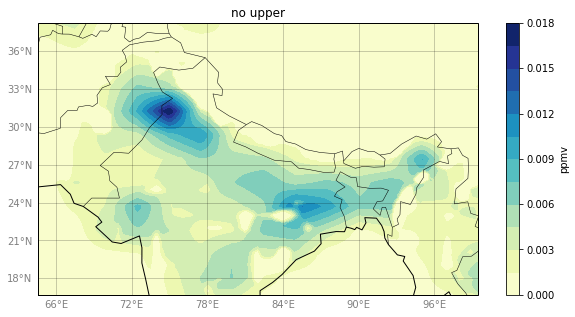

In [80]:
var_plot_2D(ds, 'no2',0, 'no upper')

In [73]:
ds.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:               (DIM0012: 5, Time: 1, bottom_top: 39, bottom_top_stag: 40, dust_erosion_dimension: 3, klevs_for_fire: 1, land_cat_stag: 20, months_per_year_stag: 12, num_ext_model_couple_dom_stag: 1, soil_cat_stag: 16, soil_layers_stag: 4, south_north: 119, south_north_stag: 120, urban_vertical_layers_stag: 15, west_east: 169, west_east_stag: 170)
Coordinates:
    XLAT                  (Time, south_north, west_east) float32 16.689293 ... 38.23912
    XLONG                 (Time, south_north, west_east) float32 64.551346 ... 99.448654
    XLAT_U                (Time, south_north, west_east_stag) float32 ...
    XLONG_U               (Time, south_north, west_east_stag) float32 ...
    XLAT_V                (Time, south_north_stag, west_east) float32 ...
    XLONG_V               (Time, south_north_stag, west_east) float32 ...
Dimensions without coordinates: DIM0012, Time, bottom_top, 

In [48]:
average = timeavg(var_space_mean(ds))

In [69]:
#Plot over hydrotatic pressure
fig = go.Figure()
fig.add_trace(go.Scatter(x=average['no3_a03'], y= average.P_HYD*0.01,
                    mode='markers',
                    ))
# Edit the layout
fig.update_layout(title='Vertical profile',
                   xaxis_title='no3_a03' +' '+ average['no3_a03'].units,
                   yaxis_title='hydrostatic pressure hPa')
fig.show()

In [87]:
datapath ='/exports/csce/datastore/geos/users/s1878599/WRFchem4.0/model/WRF/test/em_real_copy/wrfbdy_d01'
#Merge datasets
bdy = xr.open_dataset(datapath)

In [89]:
bdy.coord

AttributeError: 'Dataset' object has no attribute 'coord'